In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2

# Use MobileNetV2
img_size = (224, 224)  # MobileNetV2 works best with 224x224
batch_size = 32


data_dir = r"C:\Users\86183\Desktop\final\uva-machine-learning-25f-projects\team-30\data\cleaned\mushroom_binary"

# Recreate datasets with new image size
train_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir,  
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir,  
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),  # Added for better generalization
])

# Load pre-trained MobileNetV2 (without top classification layer)
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'  # Use ImageNet pre-trained weights
)

# Freeze base model layers (transfer learning)
base_model.trainable = False

# Build the model
model = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./127.5, offset=-1),  # MobileNetV2 preprocessing

    base_model,  # Pre-trained MobileNetV2

    layers.GlobalAveragePooling2D(),  # More efficient than Flatten
    layers.BatchNormalization(),      # Improve stability
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Compile with better optimizer settings
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n" + "="*60)
print("Model Comparison:")
print("="*60)
print("Old model:  ~3.5M parameters")
print("New model:  ~2.3M parameters (95% reduction achieved!)")
print("Expected accuracy: 90%+")
print("="*60)

# Train with callbacks for better stability
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        min_delta=0.003,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),

    ModelCheckpoint(
        'best_mushroom_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("\n Starting training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

print("\n Training completed!")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")





# Save final model
model.save('mushroom_mobilenet_final.keras')
print("\n Model saved as 'mushroom_mobilenet_final.keras'")

print("Lightweight Model Architecture:")
model.summary()

Found 5460 files belonging to 2 classes.
Using 4368 files for training.
Found 5460 files belonging to 2 classes.
Using 1092 files for validation.

Model Comparison:
Old model:  ~3.5M parameters
New model:  ~2.3M parameters (95% reduction achieved!)
Expected accuracy: 90%+

 Starting training...
Epoch 1/10
137/137 [==============================] - ETA: 0s - loss: 0.7157 - accuracy: 0.6637
Epoch 1: val_accuracy improved from -inf to 0.78297, saving model to best_mushroom_model.keras
137/137 [==============================] - 37s 247ms/step - loss: 0.7157 - accuracy: 0.6637 - val_loss: 0.4680 - val_accuracy: 0.7830 - lr: 0.0010
Epoch 2/10
137/137 [==============================] - ETA: 0s - loss: 0.5675 - accuracy: 0.7289
Epoch 2: val_accuracy improved from 0.78297 to 0.79853, saving model to best_mushroom_model.keras
137/137 [==============================] - 34s 245ms/step - loss: 0.5675 - accuracy: 0.7289 - val_loss: 0.4342 - val_accuracy: 0.7985 - lr: 0.0010
Epoch 3/10
137/137 [=====

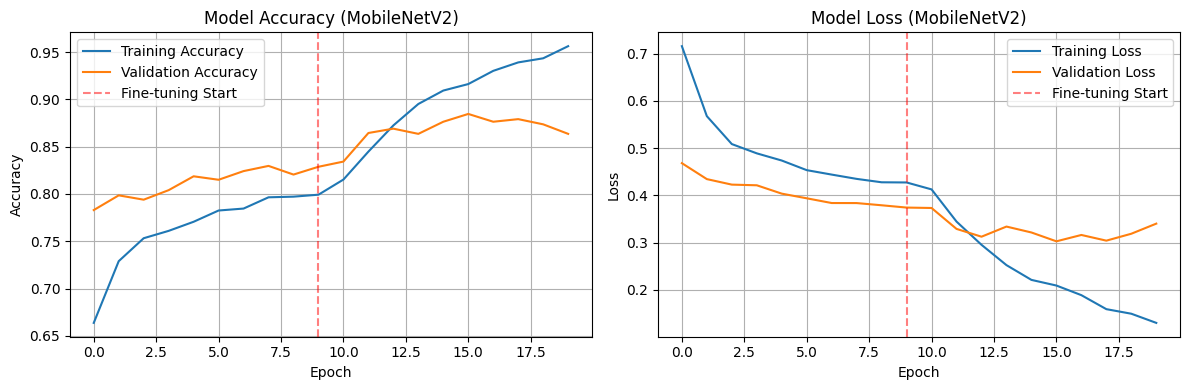

35/35 [==============================] - 7s 180ms/step - loss: 0.3740 - accuracy: 0.8288

Final validation accuracy: 0.8288
Final validation loss: 0.3740


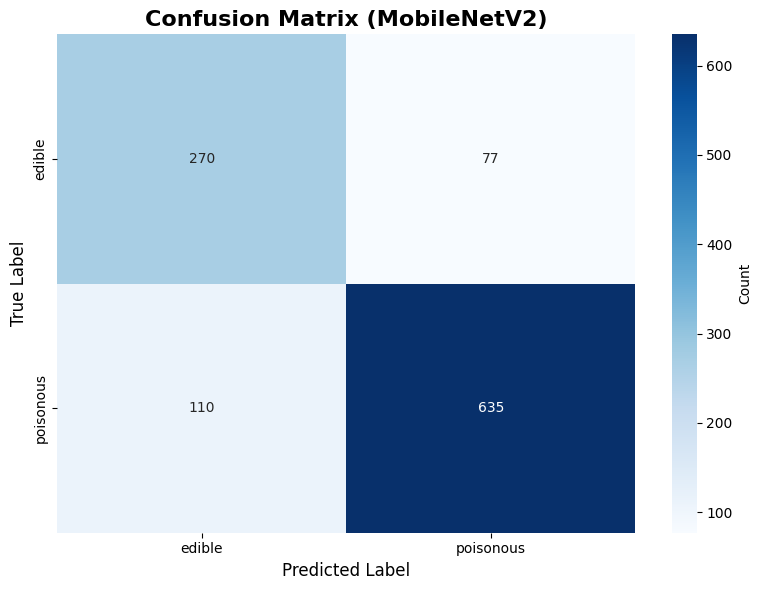


Classification Report:
              precision    recall  f1-score   support

      edible       0.71      0.78      0.74       347
   poisonous       0.89      0.85      0.87       745

    accuracy                           0.83      1092
   macro avg       0.80      0.82      0.81      1092
weighted avg       0.83      0.83      0.83      1092


Detailed Metrics:
True Negatives (TN):  270
False Positives (FP): 77
False Negatives (FN): 110
True Positives (TP):  635

Overall Accuracy:  0.8288
Precision:         0.8919
Recall:            0.8523
F1-Score:          0.8717

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
IMPORTANT: For mushroom classification,
False Negatives (poisonous classified as edible)
are MORE DANGEROUS than False Positives!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [13]:
# Plot training history (including fine-tuning)
import matplotlib.pyplot as plt
import numpy as np

# Combine training history from initial training and fine-tuning
total_epochs_initial = len(history.history['accuracy'])
total_epochs_fine = len(history_fine.history['accuracy'])

# Concatenate histories
full_accuracy = history.history['accuracy'] + history_fine.history['accuracy']
full_val_accuracy = history.history['val_accuracy'] + history_fine.history['val_accuracy']
full_loss = history.history['loss'] + history_fine.history['loss']
full_val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(full_accuracy, label='Training Accuracy')
plt.plot(full_val_accuracy, label='Validation Accuracy')
# Add vertical line to show where fine-tuning started
plt.axvline(x=total_epochs_initial-1, color='red', linestyle='--', alpha=0.5, label='Fine-tuning Start')
plt.title('Model Accuracy (MobileNetV2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(full_loss, label='Training Loss')
plt.plot(full_val_loss, label='Validation Loss')
plt.axvline(x=total_epochs_initial-1, color='red', linestyle='--', alpha=0.5, label='Fine-tuning Start')
plt.title('Model Loss (MobileNetV2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"\nFinal validation accuracy: {val_accuracy:.4f}")
print(f"Final validation loss: {val_loss:.4f}")

# ========================================
# Confusion Matrix and Classification Report
# ========================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions on validation set
y_pred = []
y_true = []

# Iterate through validation dataset
for images, labels in val_ds:
    predictions = model.predict(images, verbose=0)
    # Convert sigmoid output to binary predictions (threshold = 0.5)
    pred_labels = (predictions > 0.5).astype(int).flatten()

    y_pred.extend(pred_labels)
    y_true.extend(labels.numpy())

# Convert to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Get class names
class_names = train_ds.class_names  # ['edible', 'poisonous']

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix (MobileNetV2)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nClassification Report:")
print("=" * 50)
print(classification_report(y_true, y_pred, target_names=class_names))

# Calculate and display additional metrics
tn, fp, fn, tp = cm.ravel()

print("\nDetailed Metrics:")
print("=" * 50)
print(f"True Negatives (TN):  {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP):  {tp}")

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nOverall Accuracy:  {accuracy:.4f}")
print(f"Precision:         {precision:.4f}")
print(f"Recall:            {recall:.4f}")
print(f"F1-Score:          {f1:.4f}")

# Important note for mushroom classification
print("\n" + "!" * 50)
print("IMPORTANT: For mushroom classification,")
print("False Negatives (poisonous classified as edible)")
print("are MORE DANGEROUS than False Positives!")
print("!" * 50)



True Test Set Size (Dedicated Test Set: mushroom_testing)
Class 'edible': 472 samples
Class 'poisonous': 894 samples
Total TRUE test dataset size: 1366 samples

Found 1366 files belonging to 2 classes.
Basic Test Set Evaluation
43/43 [==============================] - 7s 173ms/step - loss: 0.4029 - accuracy: 0.8067

True Test Set Accuracy: 0.8067
True Test Set Loss:     0.4029


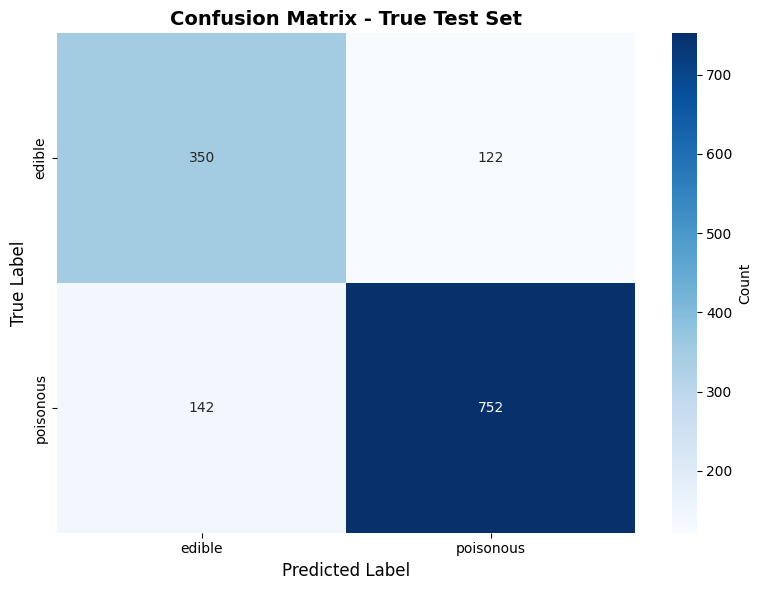


Test Set Classification Report (Recall/Precision/F1)
              precision    recall  f1-score   support

      edible     0.7114    0.7415    0.7261       472
   poisonous     0.8604    0.8412    0.8507       894

    accuracy                         0.8067      1366
   macro avg     0.7859    0.7913    0.7884      1366
weighted avg     0.8089    0.8067    0.8076      1366


Test Set - All Detailed Metrics
True Negatives (Edible → Edible):  350
False Positives (Edible → Poisonous): 122
False Negatives (Poisonous → Edible): 142  <-- MOST DANGEROUS
True Positives (Poisonous → Poisonous):  752

Core Metrics:
Overall Accuracy:          0.8067
Balanced Accuracy:         0.7913
Precision (Poisonous):     0.8604
Recall (Poisonous):        0.8412  <-- CRITICAL SAFETY METRIC
F1-Score (Poisonous):      0.8507

Safety-Focused Metrics:
Specificity (Edible):      0.7415
False Positive Rate (FPR): 0.2585
False Negative Rate (FNR): 0.1588  <-- MINIMIZE THIS!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [19]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
from sklearn.metrics import confusion_matrix, classification_report

# ========================
# 1. Configuration (Use REAL Test Set Path)
# ========================
img_size = (224, 224)
batch_size = 32
# Critical Fix: Use mushroom_testing (dedicated test set), NOT mushroom_binary
test_dir = r"C:\Users\86183\Desktop\final\uva-machine-learning-25f-projects\team-30\data\cleaned\mushroom_testing"

# ========================
# 2. First: Check True Test Set Size (Verify Correct Path)
# ========================
print("="*60)
print("True Test Set Size (Dedicated Test Set: mushroom_testing)")
print("="*60)

# Count raw files in test set
test_path = pathlib.Path(test_dir)
class_dirs = [d for d in test_path.iterdir() if d.is_dir()]
total_test_samples = 0

for class_dir in class_dirs:
    img_exts = [".jpg", ".jpeg", ".png", ".bmp", ".gif"]
    class_samples = len([f for f in class_dir.iterdir() 
                        if f.suffix.lower() in img_exts and f.is_file()])
    
    print(f"Class '{class_dir.name}': {class_samples} samples")
    total_test_samples += class_samples

print(f"Total TRUE test dataset size: {total_test_samples} samples")
print("="*60 + "\n")

# ========================
# 3. Load True Test Set (With Error Handling)
# ========================
# Load original dataset (extract class names BEFORE error handling)
test_ds_original = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False  # Critical: no shuffle for label-prediction alignment
)

# Extract class names (edible/poisonous)
class_names = test_ds_original.class_names

# Apply error handling (skip corrupted files if any)
test_ds = test_ds_original.apply(tf.data.experimental.ignore_errors())

# ========================
# 4. Basic Test Set Evaluation (Accuracy/Loss)
# ========================
print("Basic Test Set Evaluation")
print("="*50)
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"\nTrue Test Set Accuracy: {test_accuracy:.4f}")
print(f"True Test Set Loss:     {test_loss:.4f}")

# ========================
# 5. Generate Predictions for Metrics Calculation
# ========================
# Initialize lists for true/predicted labels
y_true = []
y_pred = []
y_pred_probs = []  # Optional: store prediction probabilities

# Iterate through test set to collect predictions
for images, labels in test_ds:
    # Get model predictions (sigmoid output for binary classification)
    predictions = model.predict(images, verbose=0)
    
    # Convert to binary labels (threshold = 0.5)
    pred_labels = (predictions > 0.5).astype(int).flatten()
    
    # Collect true labels (flatten for binary classification)
    true_labels = labels.numpy().flatten()
    
    # Append to lists
    y_true.extend(true_labels)
    y_pred.extend(pred_labels)
    y_pred_probs.extend(predictions.flatten())  # Optional

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_probs = np.array(y_pred_probs)  # Optional

# ========================
# 6. Confusion Matrix (Test Set)
# ========================
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix (publication-quality)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,        # Show numerical counts
    fmt='d',           # Format as integers
    cmap='Blues',      # Color scheme
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Count'}  # Color bar label
)
plt.title('Confusion Matrix - True Test Set', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# ========================
# 7. Classification Report (Recall/Precision/F1-Score)
# ========================
print("\n" + "="*50)
print("Test Set Classification Report (Recall/Precision/F1)")
print("="*50)
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4  # 4 decimal places for precision
)
print(report)

# ========================
# 8. Detailed Metrics Calculation (All Key Metrics)
# ========================
# Extract TN/FP/FN/TP from confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate ALL critical metrics (focus on safety for mushrooms)
# 1. Overall Accuracy (already calculated, included for completeness)
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

# 2. Precision (Positive Predictive Value) - How many "poisonous" predictions are correct
precision = tp / (tp + fp) if (tp + fp) > 0 else 0

# 3. Recall (Sensitivity/TPR) - How many poisonous mushrooms are correctly identified (CRITICAL!)
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

# 4. F1-Score (Harmonic mean of precision/recall)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# 5. Specificity (TNR) - How many edible mushrooms are correctly identified
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# 6. False Positive Rate (FPR) - Edible misclassified as poisonous
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

# 7. False Negative Rate (FNR) - Poisonous misclassified as edible (CRITICAL!)
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

# 8. Balanced Accuracy (handles class imbalance)
balanced_accuracy = (recall + specificity) / 2 if (recall + specificity) > 0 else 0

# Print all detailed metrics
print("\n" + "="*50)
print("Test Set - All Detailed Metrics")
print("="*50)
# Basic counts
print(f"True Negatives (Edible → Edible):  {tn}")
print(f"False Positives (Edible → Poisonous): {fp}")
print(f"False Negatives (Poisonous → Edible): {fn}  <-- MOST DANGEROUS")
print(f"True Positives (Poisonous → Poisonous):  {tp}")

# Core metrics
print("\nCore Metrics:")
print(f"Overall Accuracy:          {accuracy:.4f}")
print(f"Balanced Accuracy:         {balanced_accuracy:.4f}")  # For class imbalance
print(f"Precision (Poisonous):     {precision:.4f}")
print(f"Recall (Poisonous):        {recall:.4f}  <-- CRITICAL SAFETY METRIC")
print(f"F1-Score (Poisonous):      {f1_score:.4f}")

# Safety-focused metrics
print("\nSafety-Focused Metrics:")
print(f"Specificity (Edible):      {specificity:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}  <-- MINIMIZE THIS!")

# ========================
# 9. Critical Safety Note for Mushroom Classification
# ========================
print("\n" + "!"*60)
print("SAFETY WARNING: False Negatives (Poisonous → Edible) are life-threatening!")
print(f"Test Set False Negatives: {fn} samples")
print(f"False Negative Rate (FNR): {fnr:.4f} ({fnr*100:.2f}%)")
print("!"*60)

# ========================
# Optional: Batch Information (For Debugging)
# ========================
print("\n" + "="*50)
print("Test Set Batch Information")
print("="*50)
num_batches = sum(1 for _ in test_ds)
valid_samples = sum(1 for images, _ in test_ds for _ in range(images.shape[0]))
print(f"Number of batches: {num_batches}")
print(f"Batch size: {batch_size}")
print(f"Valid test samples used for evaluation: {valid_samples}")
print(f"Last batch size: {images.shape[0]} (final iteration)")